# Pixel-wise distance

Everything in grayscale

In [14]:
import numpy as np

In [61]:
def distance(p1, p2, coeff = 1.5):
    diff = ((p1 - p2) ** 2)
    return np.minimum(diff * coeff, np.ones(p1.shape) * 255)

# Denoising

In [16]:
from scipy import signal
def little_blur(img):
    kernel = np.ones((3, 3)) / 9.
    return signal.convolve2d(img, kernel)

In [17]:
from scipy import ndimage
def median(img, size=5):
    return ndimage.median_filter(img, size)

# Hull correction

In [18]:
from queue import Queue
def find_component(matrix, start, used):
    h, w = matrix.shape
    result = []
    v = matrix[start]

    queue = Queue()
    queue.put(start)
    used[start] = True

    while not queue.empty():
        x, y = queue.get()
        result.append((x, y))
        for dx in range(max(x-1, 0), min(x+2, h)):
            for dy in range(max(y-1, 0), min(y+2, w)):
                if matrix[dx, dy] == v and not used[dx, dy]:
                    queue.put((dx, dy))
                    used[dx, dy] = True
    return result

In [19]:
from scipy.spatial import ConvexHull
from scipy.spatial import QhullError

In [20]:
from scipy.spatial import Delaunay
def in_hull(points, hull_points):
    hull = Delaunay(hull_points)
    return hull.find_simplex(points)>=0

In [21]:
def fill_hulls_entire(mask, points, mask_opacity=80):
    points = np.asarray(points)
    mn = np.min(points, axis=0)
    mx = np.max(points, axis=0)
    rect = np.asarray([(x, y)
              for x in range(mn[0], mx[0])
              for y in range(mn[1], mx[1])
              ])

    if len(points) > 2:
        try:
            verts = ConvexHull(points).vertices
            hull = points[verts]
            is_in_hull = np.asarray(in_hull(rect, hull))
            in_hull_points = rect[np.where(is_in_hull)]
            for x, y in in_hull_points:
                mask[x, y] = mask_opacity
        except QhullError:
            print("Hull is empty. OK")

In [22]:
def hull_area(points):
    try:
        return ConvexHull(points).volume
    except QhullError:
        return 0

In [23]:
def hull_edges(points):
    try:
        return len(ConvexHull(points).vertices) - 1
    except QhullError:
        return 0

In [24]:
def filter_drops(drops, min_ratio=0.3, filling=0.5, min_edges=6):
    filtered = []
    for drop in drops:
        mn = np.min(drop, axis=0)
        mx = np.max(drop, axis=0)
        area = hull_area(drop)
        [h, w] = mx - mn
        box_area = w * h
        if area <= box_area * filling:
            continue
        ratio = min(h,w) / max(h, w)
        if ratio < min_ratio:
            continue
        if hull_edges(drop) < min_edges:
            continue
        filtered.append(drop)
    return filtered

In [25]:
def fill_by_hull(mask, mask_opacity=80):
    used = np.zeros(mask.shape, dtype=np.bool_)
    drops = []
    for (i, j), m in np.ndenumerate(mask):
        if m == mask_opacity and not used[i, j]:
            drops.append(find_component(mask, (i, j), used))
    mask.fill(0)
    for drop in filter_drops(drops):
        fill_hulls_entire(mask, drop, mask_opacity)

In [ ]:
def masked_image(background, mask, mask_opacity=80):
    foreground = np.zeros((background.height, background.width, 4))
    foreground[:, :, 3] = mask
    foreground = foreground * (mask_opacity / 255.99)
    foreground[:, :, 0].fill(255)
    foreground = Image.fromarray(foreground.astype('uint8'), "RGBA")

    background.paste(Image.new('RGB', background.size, (255, 0, 0)), mask=foreground)
    return background

# Pixelmatch

In [ ]:
!pip install pixelmatch

# Estimation

In [ ]:
from PIL import Image

In [ ]:
clear_path = '../data/stereo/train/image/004/000_0.png'
dirty_path = '../data/stereo/train/image/004/001_0.png'
mask_path  = '../data/stereo/train/image/mask/004_001_0.png'
mask_opacity = 80

# load images
clear = Image.open(clear_path)
dirty = Image.open(dirty_path)
# prepare them
clear = np.asarray(clear.convert('L'))
dirty = np.asarray(dirty.convert('L'))
# Little blur to denoise
clear = little_blur(clear)
dirty = little_blur(dirty)

In [ ]:
diff = distance(clear, dirty)

In [ ]:
# Post filtration
diff = median(diff)
diff = diff[1:-1, 1:-1]

In [ ]:
# Select partition
mask = np.where(diff > 40, mask_opacity, 0)

In [ ]:
fill_by_hull(mask)

# Visualization

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.imshow(diff, cmap="gray")
plt.axis('off')

In [ ]:
plt.imshow(mask, cmap="gray")
plt.axis('off')

In [ ]:
masked = masked_image(Image.open(dirty_path), mask)

In [ ]:
from pathlib import Path
Path(mask_path).parent.mkdir(parents=True, exist_ok=True)

In [ ]:
masked.save(mask_path)

In [ ]:
plt.imshow(masked, cmap="gray")
plt.axis('off')

# Color balance

In [ ]:
def balance_color(image):
    image = np.array(image)
    sum = np.sum(image, axis=2)
    for i in range(3):
        image[:, :, i] = image[:, :, i] * 255.99 / sum
    return Image.fromarray(image, "RGB")

In [ ]:
def balance_brightness(clean, dirty):
    clean = np.asarray(clean)
    dirty = np.array(dirty)
    dirty = dirty * (dirty.mean() / clean.mean())
    dirty = np.minimum(dirty, np.ones(dirty.shape) * 255.99)
    return Image.fromarray(dirty.astype('uint8'), "RGB")

# Applying to all images

In [ ]:
from PIL import Image
from pathlib import Path

In [ ]:
def pm_mask_drops(clear_path, dirty_path, mask_opacity=80):
    from pixelmatch.contrib.PIL import pixelmatch
    # load images
    clear = Image.open(clear_path)
    dirty = Image.open(dirty_path)
    dirty = balance_brightness(clear, dirty)
    # Get distance
    diff_img = Image.new("RGBA", clear.size)
    pixelmatch(clear, dirty, diff_img, includeAA=True, threshold=0.05, diff_mask=True, alpha=0.15)
    # Post filtration
    diff = np.asarray(diff_img.convert('L'))
    #diff = median(diff)
    #diff = diff[1:-1, 1:-1]
    # Select partition
    diff_image = Image.fromarray(diff)
    mask_image = diff_image
    return diff_image, mask_image

In [ ]:
def mask_drops(clear_path, dirty_path, mask_opacity=80):
    # load images
    clear = Image.open(clear_path)
    dirty = Image.open(dirty_path)
    # prepare them
    clear = np.array(clear)
    dirty = np.array(dirty)
    #dirty = balance_brightness(clear, dirty)
    # Little blur to denoise
    #clear = little_blur(clear)
    #dirty = little_blur(dirty)
    #clear = clear[1:-1, 1:-1]
    #dirty = dirty[1:-1, 1:-1]
    # Get distance
    diff = distance(clear, dirty)
    # Post filtration
    diff = median(diff)
    diff = median(diff)
    diff = median(diff)
    # Select partition
    #mask = np.where(diff > 40, mask_opacity, 0)
    #fill_by_hull(mask, mask_opacity)
    diff = np.max(diff, axis=2)
    diff_image = Image.fromarray(diff.astype('uint8'))
    mask_image = diff_image
    return diff_image, mask_image

In [ ]:
def load_stereo(dataset_dir = '../data/stereo/test'):
    pair_paths = []

    for path in Path(dataset_dir).glob('*.png'):
            # check if not clear
            if path.name[-9:-6] != '000':
                clear_name = path.name[:-9] + '000' + path.name[-6:]
                clear_path = Path(str(path.parent) + '/' + clear_name)
                pair_paths.append([clear_path, path])
    return pair_paths

In [ ]:
def load_derain(dataset_dir = '../data/derain/ALIGNED_PAIRS'):
    clean_dir = dataset_dir + '/CLEAN'
    dirty_dir = dataset_dir + '/CG_DROPLETS'
    pair_paths = []

    for path in Path(clean_dir).rglob('*.png'):
        path = path.relative_to(clean_dir)
        clean_path = Path(clean_dir + '/' + str(path))
        dirty_path = Path(dirty_dir + '/' + str(path))
        pair_paths.append([clean_path, dirty_path])
    return pair_paths

In [ ]:
# apply for stereo dataset
dataset_dir = '../data/stereo/train/images'
pair_paths = load_stereo(dataset_dir)

In [ ]:
# apply for derain dataset
dataset_dir = '../data/derain/ALIGNED_PAIRS'
pair_paths = load_derain(dataset_dir)

In [ ]:
mask_dir = dataset_dir + '/mask'
diff_dir = dataset_dir + '/diff'
masked_dir = dataset_dir + '/masked'
Path(mask_dir).mkdir(parents=True, exist_ok=True)
Path(diff_dir).mkdir(parents=True, exist_ok=True)
Path(masked_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
for clear_path, path in pair_paths:
    print("Processing:", clear_path, path)
    mask_path = path.relative_to(dataset_dir)
    mask_name = '_'.join(mask_path.parts)
    diff, mask = mask_drops(clear_path, path)
    #diff.save(diff_dir + '/' + mask_name)
    #print("Saved", diff_dir + '/' + mask_name)
    mask.save(mask_dir + '/' + mask_name)
    print("Saved", mask_dir + '/' + mask_name)
    masked = masked_image(Image.open(path), mask)
    masked.save(masked_dir + '/' + mask_name)
    print("Saved", masked_dir + '/' + mask_name)

In [ ]:
masked.save(mask_path)

In [ ]:
plt.imshow(masked, cmap="gray")
plt.axis('off')

# Select dataset from names

In [ ]:
masked_dir = '../data/stereo/train/image/correncted_masked'
image_dir = '../data/stereo/train/image'
save_dir = '../data/stereo/train/images'

for path in Path(masked_dir).glob('*.png'):
    path_parts = path.name.split(sep='_', maxsplit=1)
    image_path = Path(image_dir + '/' + '/'.join(path_parts))

    clear_parts = path_parts
    clear_parts[1] = '000' + clear_parts[1][3:]
    clear_path = Path(image_dir + '/' + '/'.join(clear_parts))

    save_path  = Path(save_dir + '/' + path.name)
    clear_save_path  = Path(save_dir + '/' + '_'.join(clear_parts))

    save_path.write_bytes(image_path.read_bytes())
    clear_save_path.write_bytes(clear_path.read_bytes())
    print('Saved: ', save_path)

In [55]:
mask_dir = dataset_dir + '/mask'
diff_dir = dataset_dir + '/diff'
masked_dir = dataset_dir + '/masked'
Path(mask_dir).mkdir(parents=True, exist_ok=True)
Path(diff_dir).mkdir(parents=True, exist_ok=True)
Path(masked_dir).mkdir(parents=True, exist_ok=True)

In [68]:
for clear_path, path in pair_paths:
    print("Processing:", clear_path, path)
    mask_path = path.relative_to(dataset_dir)
    mask_name = '_'.join(mask_path.parts)
    diff, mask = mask_drops(clear_path, path)
    #diff.save(diff_dir + '/' + mask_name)
    #print("Saved", diff_dir + '/' + mask_name)
    mask.save(mask_dir + '/' + mask_name)
    print("Saved", mask_dir + '/' + mask_name)
    masked = masked_image(Image.open(path), mask)
    masked.save(masked_dir + '/' + mask_name)
    print("Saved", masked_dir + '/' + mask_name)

Processing: ..\data\stereo\train\images\000_000_0.png ..\data\stereo\train\images\000_001_0.png
Saved ../data/stereo/train/images/mask/000_001_0.png
Saved ../data/stereo/train/images/masked/000_001_0.png
Processing: ..\data\stereo\train\images\000_000_1.png ..\data\stereo\train\images\000_001_1.png
Saved ../data/stereo/train/images/mask/000_001_1.png
Saved ../data/stereo/train/images/masked/000_001_1.png
Processing: ..\data\stereo\train\images\000_000_0.png ..\data\stereo\train\images\000_002_0.png
Saved ../data/stereo/train/images/mask/000_002_0.png
Saved ../data/stereo/train/images/masked/000_002_0.png
Processing: ..\data\stereo\train\images\000_000_1.png ..\data\stereo\train\images\000_002_1.png
Saved ../data/stereo/train/images/mask/000_002_1.png
Saved ../data/stereo/train/images/masked/000_002_1.png
Processing: ..\data\stereo\train\images\000_000_0.png ..\data\stereo\train\images\000_003_0.png
Saved ../data/stereo/train/images/mask/000_003_0.png
Saved ../data/stereo/train/images/m

In [60]:
masked.save(mask_path)

(-0.5, 623.5, 335.5, -0.5)

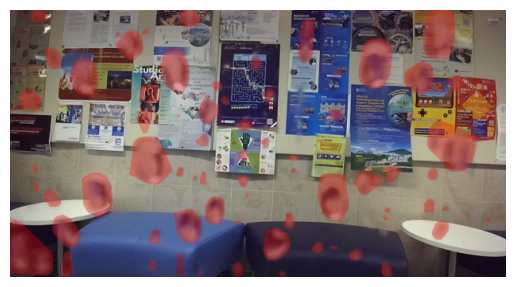

In [61]:
plt.imshow(masked, cmap="gray")
plt.axis('off')

# Select dataset from names

In [49]:
masked_dir = '../data/stereo/train/image/correncted_masked'
image_dir = '../data/stereo/train/image'
save_dir = '../data/stereo/train/images'

for path in Path(masked_dir).glob('*.png'):
    path_parts = path.name.split(sep='_', maxsplit=1)
    image_path = Path(image_dir + '/' + '/'.join(path_parts))

    clear_parts = path_parts
    clear_parts[1] = '000' + clear_parts[1][3:]
    clear_path = Path(image_dir + '/' + '/'.join(clear_parts))

    save_path  = Path(save_dir + '/' + path.name)
    clear_save_path  = Path(save_dir + '/' + '_'.join(clear_parts))

    save_path.write_bytes(image_path.read_bytes())
    clear_save_path.write_bytes(clear_path.read_bytes())
    print('Saved: ', save_path)

Saved:  ..\data\stereo\train\images\000_001_0.png
Saved:  ..\data\stereo\train\images\000_001_1.png
Saved:  ..\data\stereo\train\images\000_002_0.png
Saved:  ..\data\stereo\train\images\000_002_1.png
Saved:  ..\data\stereo\train\images\000_003_0.png
Saved:  ..\data\stereo\train\images\000_003_1.png
Saved:  ..\data\stereo\train\images\000_004_0.png
Saved:  ..\data\stereo\train\images\000_004_1.png
Saved:  ..\data\stereo\train\images\000_005_1.png
Saved:  ..\data\stereo\train\images\000_006_0.png
Saved:  ..\data\stereo\train\images\000_006_1.png
Saved:  ..\data\stereo\train\images\000_007_0.png
Saved:  ..\data\stereo\train\images\000_007_1.png
Saved:  ..\data\stereo\train\images\000_008_0.png
Saved:  ..\data\stereo\train\images\000_008_1.png
Saved:  ..\data\stereo\train\images\001_006_0.png
Saved:  ..\data\stereo\train\images\001_008_0.png
Saved:  ..\data\stereo\train\images\001_008_1.png
Saved:  ..\data\stereo\train\images\002_001_1.png
Saved:  ..\data\stereo\train\images\002_002_0.png
